# Setup

## Imports

In [119]:
import time

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score

import gd as gd
import math
from random import randint
from sklearn.ensemble import IsolationForest

## Constants

In [120]:
# Data generation
SAMPLE_TRAIN_SIZE = 100
SAMPLE_TEST_SIZE = 50
SAMPLE_OUTLIER_SIZE = 20
sigma = 10

# Generalized Deduplication
DEVIATION_BITS = 2


rng = np.random.RandomState(42)

# Load Data

## Generate data

In [121]:
# Generate train data
X_train = np.r_[(
    np.c_[((sigma * rng.randn(SAMPLE_TRAIN_SIZE, 1)).astype(int) + 60, (sigma * rng.randn(SAMPLE_TRAIN_SIZE, 1)).astype(int) + 50)],
    np.c_[((sigma * rng.randn(SAMPLE_TRAIN_SIZE, 1)).astype(int) + 50, (sigma * rng.randn(SAMPLE_TRAIN_SIZE, 1)).astype(int) + 100)],
    np.c_[((sigma * rng.randn(SAMPLE_TRAIN_SIZE, 1)).astype(int) + 100, (sigma * rng.randn(SAMPLE_TRAIN_SIZE, 1)).astype(int) + 100)]
)]

# Generate test data
X_test = np.r_[(
    np.c_[((sigma * rng.randn(SAMPLE_TEST_SIZE, 1)).astype(int) + 60, (sigma * rng.randn(SAMPLE_TEST_SIZE, 1)).astype(int) + 50)],
    np.c_[((sigma * rng.randn(SAMPLE_TEST_SIZE, 1)).astype(int) + 50, (sigma * rng.randn(SAMPLE_TEST_SIZE, 1)).astype(int) + 100)],
    np.c_[((sigma * rng.randn(SAMPLE_TEST_SIZE, 1)).astype(int) + 100, (sigma * rng.randn(SAMPLE_TEST_SIZE, 1)).astype(int) + 100)]
)]

# Generate outliers
X_outliers = np.r_[
    (np.c_[(rng.uniform(low=40, high=60, size=(int(SAMPLE_OUTLIER_SIZE/2), 1))), (rng.uniform(low=70, high=85, size=(int(SAMPLE_OUTLIER_SIZE/2), 1)))],
     np.c_[(rng.uniform(low=65, high=120, size=(int(SAMPLE_OUTLIER_SIZE/2), 1))), (rng.uniform(low=60, high=85, size=(int(SAMPLE_OUTLIER_SIZE/2), 1)))]
     )]
X_outliers = X_outliers.astype(int)

y_train = np.ones(SAMPLE_TRAIN_SIZE*3)
y_test = np.ones(SAMPLE_TEST_SIZE*3)
y_outlier = np.ones(SAMPLE_OUTLIER_SIZE - SAMPLE_OUTLIER_SIZE % 2 ) * - 1

## Perform Generalized Deduplication

In [122]:
vectorized_func = np.vectorize(gd.compress_int)

X_train_bases = vectorized_func(X_train, deviation_bits=DEVIATION_BITS, output="integer")

X_test_bases = vectorized_func(X_test, deviation_bits=DEVIATION_BITS, output="integer")

X_outliers_bases = vectorized_func(X_outliers, deviation_bits=DEVIATION_BITS, output="integer")


# Model Training

## Setup

In [123]:
gd_df_results = pd.DataFrame()
gd_ext_df_results = pd.DataFrame()
org_df_results = pd.DataFrame()
performance = pd.DataFrame(columns=['name', 'train_score', 'test_score', 'outlier_score', 'training_time', 'prediction_time'])

## Isolation Forest - Bases

In [124]:
gd_clf = IsolationForest(random_state=rng)

start_time = time.time()
gd_clf.fit(X_train_bases)
end_time = time.time()
training_time = end_time - start_time

start_time = time.time()
y_pred_train = gd_clf.predict(X_train_bases)
y_pred_test = gd_clf.predict(X_test_bases)
y_pred_outliers = gd_clf.predict(X_outliers_bases)
end_time = time.time()
prediction_time = end_time - start_time

train_score = accuracy_score(y_train, y_pred_train)
test_score = accuracy_score(y_test, y_pred_test)
outlier_score = accuracy_score(y_outlier, y_pred_outliers)

performance = performance.append({
    'name': 'Isolation Forest Bases',
    'train_score': train_score,
    'test_score': test_score,
    'outlier_score': outlier_score,
    'training_time': training_time,
    'prediction_time': prediction_time
}, ignore_index=True)

gd_df_results['gd_X'] = X_train_bases[:,0]
gd_df_results['gd_Y'] = X_train_bases[:,1]
gd_df_results['gd_score'] = gd_clf.decision_function(X_train_bases)
gd_df_results['gd_anomaly'] = gd_clf.predict(X_train_bases)
gd_df_results.head()

/tmp/ipykernel_130549/3906102531.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance = performance.append({


,gd_X,gd_Y,gd_score,gd_anomaly
0,64,36,-0.027998,-1
1,56,44,0.038438,1
2,64,44,0.002813,1
3,72,40,-0.036043,-1
4,56,48,0.066289,1


## Isolation Forest - Bases - Extended

In [125]:
gd_ext_clf = IsolationForest(random_state=rng)

start_time = time.time()
gd_ext_clf.fit(X_train_bases)
end_time = time.time()
training_time = end_time - start_time

start_time = time.time()
y_pred_train = gd_ext_clf.predict_extended(X_train_bases)
y_pred_test = gd_ext_clf.predict_extended(X_test_bases)
y_pred_outliers = gd_ext_clf.predict_extended(X_outliers_bases)
end_time = time.time()
prediction_time = end_time - start_time

train_score = accuracy_score(np.ones(SAMPLE_TRAIN_SIZE*3), y_pred_train)
test_score = accuracy_score(np.ones(SAMPLE_TEST_SIZE*3), y_pred_test)
outlier_score = accuracy_score(np.ones(SAMPLE_OUTLIER_SIZE - SAMPLE_OUTLIER_SIZE % 2 ) * - 1, y_pred_outliers)

performance = performance.append({
    'name': 'Isolation Forest Bases - Extended',
    'train_score': train_score,
    'test_score': test_score,
    'outlier_score': outlier_score,
    'training_time': training_time,
    'prediction_time': prediction_time
}, ignore_index=True)

gd_ext_df_results['gd_X'] = X_train_bases[:,0]
gd_ext_df_results['gd_Y'] = X_train_bases[:,1]
gd_ext_df_results['gd_score'] = gd_ext_clf.decision_function(X_train_bases)
gd_ext_df_results['gd_anomaly'] = gd_ext_clf.predict(X_train_bases)
gd_ext_df_results.head()

/tmp/ipykernel_130549/2979943179.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance = performance.append({


,gd_X,gd_Y,gd_score,gd_anomaly
0,64,36,-0.027903,-1
1,56,44,0.043415,1
2,64,44,-0.001265,-1
3,72,40,-0.033268,-1
4,56,48,0.071627,1


## Isolation Forest - Original Data

In [126]:
org_clf = IsolationForest(random_state=rng)

start_time = time.time()
org_clf.fit(X_train_bases)
end_time = time.time()
training_time = end_time - start_time

start_time = time.time()
y_pred_train = org_clf.predict(X_train)
y_pred_test = org_clf.predict(X_test)
y_pred_outliers = org_clf.predict(X_outliers)
end_time = time.time()
prediction_time = end_time - start_time

train_score = accuracy_score(np.ones(SAMPLE_TRAIN_SIZE*3), y_pred_train)
test_score = accuracy_score(np.ones(SAMPLE_TEST_SIZE*3), y_pred_test)
outlier_score = accuracy_score(np.ones(SAMPLE_OUTLIER_SIZE - SAMPLE_OUTLIER_SIZE % 2 ) * - 1, y_pred_outliers)

performance = performance.append({
    'name': 'Isolation Forest Original',
    'train_score': train_score,
    'test_score': test_score,
    'outlier_score': outlier_score,
    'training_time': training_time,
    'prediction_time': prediction_time
}, ignore_index=True)

org_df_results['org_X'] = X_train[:,0]
org_df_results['org_Y'] = X_train[:,1]
org_df_results['org_score'] = org_clf.decision_function(X_train)
org_df_results['org_anomaly'] = org_clf.predict(X_train)
org_df_results.head()

/tmp/ipykernel_130549/192467859.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance = performance.append({


,org_X,org_Y,org_score,org_anomaly
0,64,36,-0.031921,-1
1,59,46,0.061430,1
2,66,47,0.020587,1
3,75,42,-0.068172,-1
4,58,49,0.070802,1


# Calculations

### Count amount of base occurences

In [127]:
array = X_train_bases#your numpy array of lists
new_array = [tuple(row) for row in array]
unique, idx, counts = np.unique(new_array, axis=0, return_index=True, return_counts=True)

df_unique = pd.DataFrame()
df_unique['gd_X'] = unique[:,0]
df_unique['gd_Y'] = unique[:,1]
df_unique['gd_counts'] = counts
df_unique['gd_org_idx'] = idx
df_unique.head()

,gd_X,gd_Y,gd_counts,gd_org_idx
0,16,96,1,162
1,28,92,1,136
2,28,100,1,185
3,32,52,1,74
4,32,100,1,154


### Prepare data for calculation

In [128]:
# Merge gd results and original results in single dataframe
df_results = pd.DataFrame()
df_results['org_X'] = org_df_results['org_X']
df_results['gd_X'] = gd_df_results['gd_X']
df_results['org_Y'] = org_df_results['org_Y']
df_results['gd_Y'] = gd_df_results['gd_Y']
df_results['org_score'] = org_df_results['org_score']
df_results['gd_score'] = gd_df_results['gd_score']
df_results['org_score_converted'] = df_results['org_score'].sub(0.5).mul(-1) # Convert sklearn score range to paper score range [-0.5;0.5] -> [0;1]
df_results['gd_score_converted'] = df_results['gd_score'].sub(0.5).mul(-1) # Convert sklearn score range to paper score range [-0.5;0.5] -> [0;1]
df_results['org_anomaly'] = org_df_results['org_anomaly']
df_results['gd_anomaly'] = gd_df_results['gd_anomaly']

df_results

,org_X,gd_X,org_Y,gd_Y,org_score,gd_score,org_score_converted,gd_score_converted,org_anomaly,gd_anomaly
0,64,64,36,36,-0.031921,-0.027998,0.531921,0.527998,-1,-1
1,59,56,46,44,0.061430,0.038438,0.438570,0.461562,1,1
2,66,64,47,44,0.020587,0.002813,0.479413,0.497187,1,1
3,75,72,42,40,-0.068172,-0.036043,0.568172,0.536043,-1,-1
4,58,56,49,48,0.070802,0.066289,0.429198,0.433711,1,1
...,...,...,...,...,...,...,...,...,...,...
295,105,104,95,92,0.024691,0.046697,0.475309,0.453303,1,1
296,90,88,98,96,0.051831,0.071349,0.448169,0.428651,1,1
297,99,96,91,88,0.046631,0.007712,0.453369,0.492288,1,1
298,92,92,96,96,0.057608,0.069022,0.442392,0.430978,1,1


In [129]:

# Add score and anomaly to df_uniques
scores = []
scores_converted = []
anomaly = []
for index, row in df_unique.iterrows():
    result = df_results[(df_results.gd_X == row.gd_X) & (df_results.gd_Y == row.gd_Y)].iloc[0]
    scores.append(result.gd_score)
    scores_converted.append(result.gd_score_converted)
    anomaly.append(result.gd_anomaly)

df_unique['gd_anomaly'] = anomaly
df_unique['gd_score'] = scores
df_unique['gd_score_converted'] = scores_converted

# Define constants
n_samples = len(df_results)
n_uniques = len(df_unique)
df_unique.head()

,gd_X,gd_Y,gd_counts,gd_org_idx,gd_anomaly,gd_score,gd_score_converted
0,16,96,1,162,-1.0,-0.169763,0.669763
1,28,92,1,136,-1.0,-0.103915,0.603915
2,28,100,1,185,-1.0,-0.076649,0.576649
3,32,52,1,74,-1.0,-0.138953,0.638953
4,32,100,1,154,-1.0,-0.027682,0.527682


### Perform calculation

In [130]:
def H(i):
    return np.log(i) + 0.5772156649 # euler's constant

def c(n):
    return 2*H(n-1) - ((2*(n-1))/n)

Calculation 1:  $\log_2(s(x,n)) \cdot c(n) = E(h(x))$

In [131]:
result = []
for index, row in df_unique.iterrows():
    res = -(np.log2(row.gd_score_converted) * c(n_samples)) + np.log2(row.gd_counts)
    result.append(res)
df_unique['E[H(x)]+log_2[count(x)]'] = result
df_unique.head()

,gd_X,gd_Y,gd_counts,gd_org_idx,gd_anomaly,gd_score,gd_score_converted,E[H(x)]+log_2[count(x)]
0,16,96,1,162,-1.0,-0.169763,0.669763,6.107751
1,28,92,1,136,-1.0,-0.103915,0.603915,7.684704
2,28,100,1,185,-1.0,-0.076649,0.576649,8.388691
3,32,52,1,74,-1.0,-0.138953,0.638953,6.825346
4,32,100,1,154,-1.0,-0.027682,0.527682,9.740896


Calculation 2: $S(x, n_{samples})=2^{-\frac{E(h(x))}{c(n_{samples})}}$

In [132]:
result = []
for index, row in df_unique.iterrows():
    res = 2 ** - (row['E[H(x)]+log_2[count(x)]'] / c(n_samples))
    result.append(res)
df_unique['S(x,n_samples)'] = result
df_unique

,gd_X,gd_Y,gd_counts,gd_org_idx,gd_anomaly,gd_score,gd_score_converted,E[H(x)]+log_2[count(x)],"S(x,n_samples)"
0,16,96,1,162,-1.0,-0.169763,0.669763,6.107751,0.669763
1,28,92,1,136,-1.0,-0.103915,0.603915,7.684704,0.603915
2,28,100,1,185,-1.0,-0.076649,0.576649,8.388691,0.576649
3,32,52,1,74,-1.0,-0.138953,0.638953,6.825346,0.638953
4,32,100,1,154,-1.0,-0.027682,0.527682,9.740896,0.527682
...,...,...,...,...,...,...,...,...,...
164,116,100,1,260,-1.0,-0.054360,0.554360,8.989356,0.554360
165,116,104,1,221,-1.0,-0.061560,0.561560,8.792725,0.561560
166,116,108,2,274,-1.0,-0.063980,0.563980,9.727198,0.528156
167,120,84,1,220,-1.0,-0.125100,0.625100,7.159336,0.625100


# Performance evaluation

## Overview

In [133]:
performance

,name,train_score,test_score,outlier_score,training_time,prediction_time
0,Isolation Forest Bases,0.69,0.56,0.95,0.265212,0.179453
1,Isolation Forest Bases - Extended,0.78,0.66,0.95,0.295261,1.299102
2,Isolation Forest Original,0.686667,0.58,0.95,0.250787,0.124414


## Confusion Matrices

/tmp/ipykernel_130549/1683278025.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_130549/1683278025.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_130549/1683278025.py:55: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


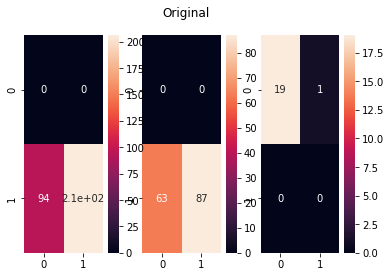

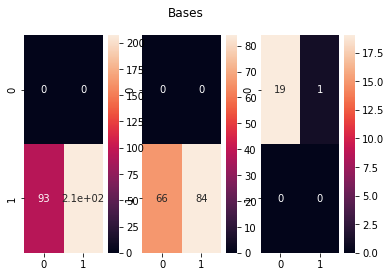

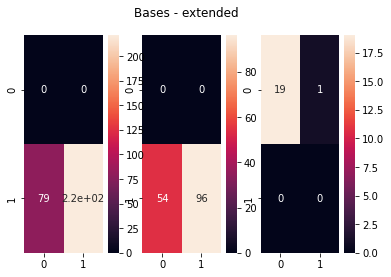

In [139]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
y_train = y_train.clip(min=0)
y_test = y_test.clip(min=0)
y_outlier = y_outlier.clip(min=0)

# Original
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle("Original")

y_train_pred =  org_clf.predict(X_train).clip(min=0)
cf_matrix = confusion_matrix(y_train, y_train_pred)
sns.heatmap(cf_matrix, annot=True, ax=ax1)

y_test_pred =  org_clf.predict(X_test).clip(min=0)
cf_matrix = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cf_matrix, annot=True, ax=ax2)

y_outlier_pred =  org_clf.predict(X_outliers).clip(min=0)
cf_matrix = confusion_matrix(y_outlier, y_outlier_pred)
sns.heatmap(cf_matrix, annot=True, ax=ax3)
fig.show()

# GD
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle("Bases")

y_train_pred =  gd_clf.predict(X_train_bases).clip(min=0)
cf_matrix = confusion_matrix(y_train, y_train_pred)
sns.heatmap(cf_matrix, annot=True, ax=ax1)

y_test_pred =  gd_clf.predict(X_test_bases).clip(min=0)
cf_matrix = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cf_matrix, annot=True, ax=ax2)

y_outlier_pred =  gd_clf.predict(X_outliers_bases).clip(min=0)
cf_matrix = confusion_matrix(y_outlier, y_outlier_pred)
sns.heatmap(cf_matrix, annot=True, ax=ax3)
fig.show()

# GD Extended
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle("Bases - extended")
y_train_pred =  gd_ext_clf.predict(X_train_bases).clip(min=0)
cf_matrix = confusion_matrix(y_train, y_train_pred)
sns.heatmap(cf_matrix, annot=True, ax=ax1)

y_test_pred =  gd_ext_clf.predict(X_test_bases).clip(min=0)
cf_matrix = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cf_matrix, annot=True, ax=ax2)

y_outlier_pred =  gd_ext_clf.predict(X_outliers_bases).clip(min=0)
cf_matrix = confusion_matrix(y_outlier, y_outlier_pred)
sns.heatmap(cf_matrix, annot=True, ax=ax3)
fig.show()

# Data Visualization

## Data before and after gd - scatter

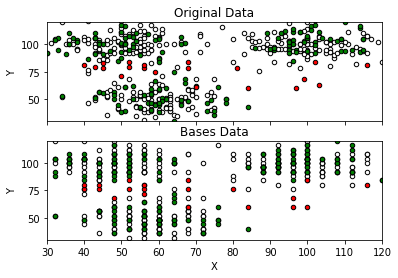

In [135]:
fig, (ax1, ax2) = plt.subplots(2, 1)

b1 = ax1.scatter(X_train[:, 0], X_train[:, 1], c="white", s=20, edgecolor="k")
b2 = ax1.scatter(X_test[:, 0], X_test[:, 1], c="green", s=20, edgecolor="k")
c = ax1.scatter(X_outliers[:, 0], X_outliers[:, 1], c="red", s=20, edgecolor="k")
ax1.set_title("Original Data")

b1 = ax2.scatter(X_train_bases[:, 0], X_train_bases[:, 1], c="white", s=20, edgecolor="k")
b2 = ax2.scatter(X_test_bases[:, 0], X_test_bases[:, 1], c="green", s=20, edgecolor="k")
c = ax2.scatter(X_outliers_bases[:, 0], X_outliers_bases[:, 1], c="red", s=20, edgecolor="k")
ax1.set_title("Original Data")
ax2.set_title("Bases Data")

ax1.set_xlim([30,120])
ax2.set_xlim([30,120])

ax1.set_ylim([30,120])
ax2.set_ylim([30,120])

ax1.set_xticklabels([])

ax1.set_ylabel('Y')
ax2.set_ylabel('Y')
ax2.set_xlabel('X')
plt.show()

## Decision Function - scatter/contour

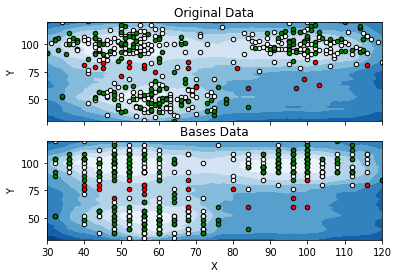

In [136]:
xx, yy = np.meshgrid(np.linspace(30, 120, 50), np.linspace(30, 120, 50))

fig, (ax1, ax2) = plt.subplots(2, 1)

#Original
Z = org_clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
ax1.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

ax1.scatter(X_train[:, 0], X_train[:, 1], c="white", s=20, edgecolor="k")
ax1.scatter(X_test[:, 0], X_test[:, 1], c="green", s=20, edgecolor="k")
ax1.scatter(X_outliers[:, 0], X_outliers[:, 1], c="red", s=20, edgecolor="k")

# Bases
Z = gd_clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
ax2.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

ax2.scatter(X_train_bases[:, 0], X_train_bases[:, 1], c="white", s=20, edgecolor="k")
ax2.scatter(X_test_bases[:, 0], X_test_bases[:, 1], c="green", s=20, edgecolor="k")
ax2.scatter(X_outliers_bases[:, 0], X_outliers_bases[:, 1], c="red", s=20, edgecolor="k")

# Plot settings
ax1.set_title("Original Data")
ax2.set_title("Bases Data")

ax1.set_xlim([30,120])
ax2.set_xlim([30,120])

ax1.set_ylim([30,120])
ax2.set_ylim([30,120])

ax1.set_xticklabels([])

ax1.set_ylabel('Y')
ax2.set_ylabel('Y')
ax2.set_xlabel('X')


plt.show()

## Bases - density

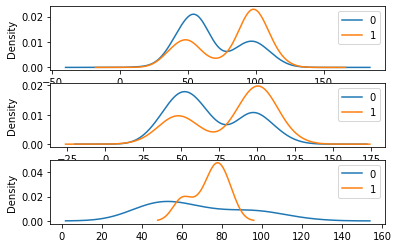

In [137]:
fig, axes = plt.subplots(nrows=3, ncols=1)
pd.DataFrame(X_train_bases).plot.density(ax=axes[0])
pd.DataFrame(X_test_bases).plot.density(ax=axes[1])
pd.DataFrame(X_outliers_bases).plot.density(ax=axes[2])
plt.show()

## Calculation - scatter

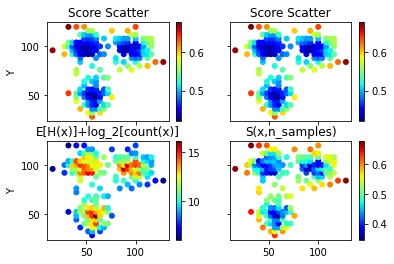

In [138]:
fig, axs = plt.subplots(2, 2)
ax1 = axs[0,0]
ax2 = axs[0,1]
ax3 = axs[1,0]
ax4 = axs[1,1]

points = ax1.scatter(df_unique.gd_X, df_unique.gd_Y, c=df_unique.gd_score_converted,cmap="jet", lw=0)
plt.colorbar(points,ax=ax1)
ax1.set_title("Score Scatter")

points = ax2.scatter(df_unique.gd_X, df_unique.gd_Y, c=df_unique.gd_score_converted,cmap="jet", lw=0)
plt.colorbar(points,ax=ax2)
ax2.set_title("Score Scatter")

points = ax3.scatter(df_unique.gd_X, df_unique.gd_Y, c=df_unique['E[H(x)]+log_2[count(x)]'],cmap="jet", lw=0)
plt.colorbar(points,ax=ax3)
ax3.set_title("E[H(x)]+log_2[count(x)]")

points = ax4.scatter(df_unique.gd_X, df_unique.gd_Y, c=df_unique['S(x,n_samples)'],cmap="jet", lw=0)
plt.colorbar(points,ax=ax4)
ax4.set_title("S(x,n_samples)")

ax1.set_xticklabels([])
ax2.set_xticklabels([])

ax2.set_yticklabels([])
ax4.set_yticklabels([])

ax3.set_ylabel('Y')
ax1.set_ylabel('Y')
plt.show()

# Formulas

## Definitions

$n$: number of samples

$c(n)$: average path length of unsuccessfull search - constant given n

$H(i)$: harmonic number - estimated by $ln(i) + e$

$h(x)$: path length - number of edges x traverses an itree from the root node

$n$: amount of instances/nodes - amount of bases in our situation

$s$: anomaly score -
$s(x,n)=2^{\frac{-E(h(x))}{c(n)}}$

$E(h(x))$: average of $h(x)$ from a collection of isolation trees.

$f_{base}=\log_2(n_{base})$

---

## Deriving equations
1:

$\log_2(s) \cdot c(n)=-E(h(x))$

2:

$\log_2(s)=-\frac{E(h(x))+\log_2(f_{base})}{c(n_{samples})}$

3:

$\log_2(s) \cdot c(n) = -E(h(x))$

4:

$\log_2(s) = -\frac{E(h(x))+\log_2(f_{base})}{c(n_{samples})}$


---


